## Tasks

In [1]:
from dataclasses import dataclass, fields

@dataclass
class Task:
    is_project_private: int
    is_user_approved: int
    load_packit_yaml: int
    set_status: int
        
    @property
    def total(self):
        return sum(getattr(self, field.name) for field in fields(self.__class__))
    
    def __mul__(self, num):
        if not isinstance(num, int):
            raise TypeError(f"unsupported operand type(s) for *: {type(self)!r} and {type(num)!r}")
        return Task(*[num * getattr(self, field.name) for field in fields(self.__class__)])
    
    __rmul__ = __mul__
    
    def __add__(self, obj):
        if not isinstance(obj, Task) and not isinstance(obj, int):
            raise TypeError(f"unsupported operand type(s) for +: {type(self)!r} and {type(obj)!r}")
        if isinstance(obj, int) and obj != 0:
            raise TypeError(f"adding {obj!r} to an {type(self)!r} is not supported")
        if isinstance(obj, int) and obj == 0:
            obj = Task(*[0] * len(fields(self.__class__)))
        return Task(*[(getattr(self, field.name) + getattr(obj, field.name)) for field in fields(self.__class__)])
    
    __radd__ = __add__

## Estimating the number of API calls

In [2]:
from collections import namedtuple

metrics = [
    "prs_per_hour_per_org", 
    "total_is_project_private", 
    "total_is_user_approved", 
    "total_load_packit_yaml", 
    "total_set_status",
    "grand_total",
]

class APICallMetrics(namedtuple("APICallMetrics", metrics)):
    def __repr__(self):
        return "\n".join(f"{field} = {getattr(self, field)}" for field in self._fields)
    
def github_api_calls(
    # The number of chroots configured to be built in Copr
    chroots=3, 
    # GitHub server-to-server rate limit per hour
    rate_limit=5000,
    # Calls to load .packit.yaml.
    # The current implementation cycles through a list of 7 files.
    # If the config file is .packit.yaml, this is loaded from 2 calls.
    # If the config file is packit.yaml, it's loaded from 5 calls.
    # The +1 call is to try to find the specfile path.
    load_packit_yaml=2+1,
    # Whether builds are enabled
    builds_enabled=True, 
    # Whether tests are enabled
    tests_enabled=True, 
    # Load packit.yaml once during the pipeline run
    load_packit_yaml_once=False, 
    # Set all flags (including test ones) when the build status changes
    all_flags=True,
    # Check if the repo is private only in the beginning
    is_private_once=False,
):
    build_status_flag = int(builds_enabled)
    test_status_flag = int(tests_enabled)
    tasks = {
        "PR is updated": Task(
            # https://github.com/packit/packit-service/blob/bc1f66bb82aa7c013bde8b8e670ce7e02f55de41/packit_service/worker/jobs.py#L156
            is_project_private=1,
            # https://github.com/packit/packit-service/blob/bc1f66bb82aa7c013bde8b8e670ce7e02f55de41/packit_service/worker/allowlist.py#L275
            is_user_approved=2,
            # https://github.com/packit/packit-service/blob/bc1f66bb82aa7c013bde8b8e670ce7e02f55de41/packit_service/worker/events/event.py#L415
            load_packit_yaml=load_packit_yaml,
            set_status=chroots * (build_status_flag + test_status_flag)
        ),
        "Submit Copr build": Task(
            is_project_private=0,
            is_user_approved=0,
            load_packit_yaml=0,
            set_status=chroots * (build_status_flag + test_status_flag),
        ),
    }
    load_packit_yaml = load_packit_yaml if not load_packit_yaml_once else 0
    flags_to_set = (build_status_flag + test_status_flag) if all_flags else build_status_flag
    is_private = 0 if is_private_once else 1
    task = Task(is_private, 0, load_packit_yaml, flags_to_set)
    tasks.update({
        "SRPM build started": chroots * task,
        "SRPM build finished": chroots * task,
        "RPM build started": chroots * task,
        "RPM build finished": chroots * task,
    })
    if tests_enabled:
        task = Task(is_private, 0, load_packit_yaml, test_status_flag)
        tasks.update({
        "Tests started": chroots * task,
        "Tests finished": chroots * task,
    })
    total_is_project_private = sum(task.is_project_private for task in tasks.values())
    total_is_user_approved = sum(task.is_user_approved for task in tasks.values())
    total_load_packit_yaml = sum(task.load_packit_yaml for task in tasks.values())
    total_set_status = sum(task.set_status for task in tasks.values())
    grand_total = sum(tasks.values()).total
    prs_per_hour_per_org = int(rate_limit / grand_total)
    
    return APICallMetrics(
        prs_per_hour_per_org, 
        total_is_project_private, 
        total_is_user_approved, 
        total_load_packit_yaml, 
        total_set_status,
        grand_total,
    )

In [3]:
github_api_calls(
    chroots=3, 
    rate_limit=5000, 
    load_packit_yaml=2+1, 
    builds_enabled=True, 
    tests_enabled=True
)

prs_per_hour_per_org = 41
total_is_project_private = 19
total_is_user_approved = 2
total_load_packit_yaml = 57
total_set_status = 42
grand_total = 120

In [4]:
import matplotlib.pyplot as pp
%matplotlib inline

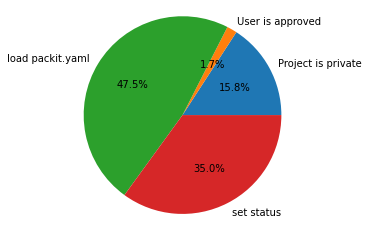

In [5]:
labels = ["Project is private", "User is approved", "load packit.yaml", "set status"]
sizes = github_api_calls(
    chroots=3, 
    rate_limit=5000, 
    load_packit_yaml=2+1, 
    builds_enabled=True, 
    tests_enabled=True
)[1:-1]
fig1, ax1 = pp.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')

pp.show()

## A few common scenarios

In [6]:
print("3 chroots, config is called '.packit.yaml'")
github_api_calls(
    chroots=3, 
    rate_limit=5000, 
    load_packit_yaml=2+1, 
    builds_enabled=True, 
    tests_enabled=True
)

3 chroots, config is called '.packit.yaml'


prs_per_hour_per_org = 41
total_is_project_private = 19
total_is_user_approved = 2
total_load_packit_yaml = 57
total_set_status = 42
grand_total = 120

In [7]:
print("6 chroots, config is called '.packit.yaml'")
github_api_calls(
    chroots=6, 
    rate_limit=5000, 
    load_packit_yaml=2+1, 
    builds_enabled=True, 
    tests_enabled=True
)

6 chroots, config is called '.packit.yaml'


prs_per_hour_per_org = 21
total_is_project_private = 37
total_is_user_approved = 2
total_load_packit_yaml = 111
total_set_status = 84
grand_total = 234

In [8]:
print("3 chroots, config is called 'packit.yaml'")
github_api_calls(
    chroots=3, 
    rate_limit=5000, 
    load_packit_yaml=5+1, 
    builds_enabled=True, 
    tests_enabled=True
)

3 chroots, config is called 'packit.yaml'


prs_per_hour_per_org = 28
total_is_project_private = 19
total_is_user_approved = 2
total_load_packit_yaml = 114
total_set_status = 42
grand_total = 177

In [9]:
print("6 chroots, config is called 'packit.yaml'")
github_api_calls(
    chroots=6, 
    rate_limit=5000, 
    load_packit_yaml=5+1, 
    builds_enabled=True, 
    tests_enabled=True
)

6 chroots, config is called 'packit.yaml'


prs_per_hour_per_org = 14
total_is_project_private = 37
total_is_user_approved = 2
total_load_packit_yaml = 222
total_set_status = 84
grand_total = 345

In [10]:
print("6 chroots, config is called '.packit.yaml', no tests")
github_api_calls(
    chroots=6, 
    rate_limit=5000, 
    load_packit_yaml=2+1, 
    builds_enabled=True, 
    tests_enabled=False
)

6 chroots, config is called '.packit.yaml', no tests


prs_per_hour_per_org = 36
total_is_project_private = 25
total_is_user_approved = 2
total_load_packit_yaml = 75
total_set_status = 36
grand_total = 138

## Ways to improve things

The main issue seems to be that `task.steve_jobs.process_message` re-creates the context of the pipeline by getting information from GitHub: checks if the project is private, if the user is approved to run the pipeline, and load the package config (`.packit.yaml`).

All this could be avoided by looking up the pipeline when an event arrives (Copr events, testing farm events - when these are received there already needs to be a pipeline created, otherwise they are invalid), and getting this information from the pipeline.

The only time it makes sense to load this from GitHub is when the pipeline is started, for example when the PR event is received.

Let's pick the worst case from the list above (*6 chroots, config is called 'packit.yaml'*) as a reference, and check how the number of API calls change if we apply the above.

**Load the package config only once per pipeline run** to increase the number of possible runs from 14 to 38 (~171% increase). This is achived by reducing the number of API calls to get the package config from 222 to 6.

In [11]:
github_api_calls(
    chroots=6, 
    rate_limit=5000,
    load_packit_yaml=5+1,
    builds_enabled=True,
    tests_enabled=True,
    load_packit_yaml_once=True)

prs_per_hour_per_org = 38
total_is_project_private = 37
total_is_user_approved = 2
total_load_packit_yaml = 6
total_set_status = 84
grand_total = 129

**Don't update the test flags while the build is in progress**, to get to 47 PRs/hour/org (a 235% increase in total), thanks to shaving of 24 API calls to update the status flags.

In [12]:
github_api_calls(
    chroots=6, 
    rate_limit=5000, 
    load_packit_yaml=5+1, 
    builds_enabled=True, 
    tests_enabled=True, 
    load_packit_yaml_once=True,
    all_flags=False)

prs_per_hour_per_org = 47
total_is_project_private = 37
total_is_user_approved = 2
total_load_packit_yaml = 6
total_set_status = 60
grand_total = 105

**Reduce the number of calls to get the package config**, and don't search for the specfile path ([packit/packit#1799](https://github.com/packit/packit/issues/1799)). This is an increase in the possible PRs handled per hour per org of ~250%.

Reducing the number of calls to get the package config has probably a greater impact when Packit is enabled for all repositories in the org, but only a few of those repositories have a package config present. In this case events from repositories which don't have a package config will consume only 2 API calls (1 to check if the repo is private, and 1 to find out that there is no package config), instead of 9 API calls.

In [13]:
github_api_calls(
    chroots=6, 
    rate_limit=5000, 
    load_packit_yaml=2, 
    builds_enabled=True, 
    tests_enabled=True, 
    load_packit_yaml_once=True, 
    all_flags=False)

prs_per_hour_per_org = 49
total_is_project_private = 37
total_is_user_approved = 2
total_load_packit_yaml = 2
total_set_status = 60
grand_total = 101

By **checking if the repo is private only once**, when the event that the PR was updated is received and the pipeline created, a further 55% increase can be achieved, which brings us to a **442% increase compared to the current state**.

The number of API calls drops from 345 to 65.

In [14]:
github_api_calls(
    chroots=6, 
    rate_limit=5000, 
    load_packit_yaml=2, 
    builds_enabled=True, 
    tests_enabled=True, 
    load_packit_yaml_once=True, 
    all_flags=False, 
    is_private_once=True)

prs_per_hour_per_org = 76
total_is_project_private = 1
total_is_user_approved = 2
total_load_packit_yaml = 2
total_set_status = 60
grand_total = 65

The above is a 246% improvement even for the best case scenario, by dropping the number of API calls per pipeline from 120 to 35.

In [15]:
github_api_calls(
    chroots=3,
    rate_limit=5000,
    load_packit_yaml=2,
    builds_enabled=True,
    tests_enabled=True,
    load_packit_yaml_once=True,
    all_flags=False,
    is_private_once=True)

prs_per_hour_per_org = 142
total_is_project_private = 1
total_is_user_approved = 2
total_load_packit_yaml = 2
total_set_status = 30
grand_total = 35

From this point on, the number of API calls could be further reduced only by having fewer status flags (merging flags for different chroots) or making fewer updates to these flags. Both of these could make the user experiance worse.

Note, that the above assumes that pipelines are never running in parallel, which is probably not the case, for example, when PRs are updated while a previous pipeline is still in progress. In these situations old pipeline runs could still consume from the GitHub API rate limit (and maybe override statuses?). This could be solved by canceling Copr builds and test runs belonging to pipelines which become irrelevant ([packit/packit-service#5](https://github.com/packit/packit-service/issues/5)).